In [ ]:
# Install required dependencies
!pip install camelot-py[base]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import camelot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
source_dir = "/content/drive/MyDrive/SI 671 - Final Project Data/"

Mounted at /content/drive


# Data Preprocessing

In [ ]:
fire_incidents = pd.read_csv(f"{source_dir}incidents-ca-fires-other.csv")
print(fire_incidents.columns)
print("Total Incidents: ", len(fire_incidents))
fire_incidents.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SI 671 - Final Project Data/incidents-ca-fires-other.csv'

In [ ]:
# Read ZCTA file to obtain zip codes
zcta = gpd.read_file(f"{source_dir}tl_2024_us_zcta520/tl_2024_us_zcta520.shp")

ca_zcta = zcta[zcta['ZCTA5CE20'].str.startswith(('90', '91', '92', '93', '94', '95', '96'))]
print(f"Number of CA ZCTAs: {len(ca_zcta)}")
print(f"Columns: {ca_zcta.columns.tolist()}")

print(f"\nMissing latitude: {fire_incidents['incident_latitude'].isna().sum()}")
print(f"Missing longitude: {fire_incidents['incident_longitude'].isna().sum()}")

In [ ]:
fire_incidents.columns

In [ ]:
# geometry = [Point(xy) for xy in zip(fire_incidents['incident_longitude'], fire_incidents['incident_latitude'])]
# fire_gdf = gpd.GeoDataFrame(fire_incidents, geometry = geometry)

fire_gdf = gpd.GeoDataFrame(
    fire_incidents,
    geometry=gpd.points_from_xy(
        fire_incidents['incident_longitude'],
        fire_incidents['incident_latitude']
    ),
    crs="EPSG:4326"
)

if fire_gdf.crs != ca_zcta.crs:
    fire_gdf = fire_gdf.to_crs(ca_zcta.crs)

fires_with_zip = gpd.sjoin_nearest(fire_gdf, ca_zcta, how='left')
fires_with_zip = fires_with_zip.rename(columns={'ZCTA5CE20': 'zip_code'})

matched = fires_with_zip['zip_code'].notna().sum()
unmatched = fires_with_zip['zip_code'].isna().sum()

print(f"Matched to ZIP: {matched} ({matched/len(fires_with_zip)*100:.1f}%)")
print(f"Not matched: {unmatched} ({unmatched/len(fires_with_zip)*100:.1f}%)")

In [ ]:
def extract_table_from_pdfs(pdf_path, set_flavor='lattice', cols_to_skip = 4,  sub_categories=5):
    try:
      print("Exttracting data from pdf...")
      pdf_tables = camelot.read_pdf(pdf_path, pages="all", flavor=set_flavor)
      print(f"Dataframe created frome {pdf_path}")
    except Exception as e:
      print(f"{set_flavor} not found - table might be without borders: {e}")

    df_list = []
    for table in pdf_tables:
        df_list.append(table.df)

    df = pd.concat(df_list)
    df.columns = df.iloc[1]
    df = df.iloc[2:].reset_index(drop=True)
    mask = df['Zip'].astype(str).str.upper().isin(['ZIP', 'ZIP_CODE', 'ZIP CODE'])
    df = df[~mask]

    new_cols = []

    for i in range(len(df.columns)):
      if i < cols_to_skip:
        new_cols.append(df.columns[i])  # First 4 columns unchanged
        continue
      category_idx = (i - 4) // sub_categories
      categories = ['Low', 'Medium', 'High']
      category = categories[category_idx]
      subcol = df.columns[i]
      new_cols.append(f"{category}_{subcol}")

    df.columns = new_cols

    df = df.dropna(how='all')
    df = df.reset_index(drop=True)
    non_numeric = ['Zip', 'ZIP_Code', 'County', 'Is Distressed Area', 'Region']
    for col in df.columns:
        if col not in non_numeric:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df =  df[df['Zip'].str.strip() != '']

    return df

In [ ]:
res_policy_counts = extract_table_from_pdfs(f"{source_dir}residential-policy-count.pdf")
res_policy_premium = extract_table_from_pdfs(f"{source_dir}residential-policy-premium.pdf")
res_policy_exposure = extract_table_from_pdfs(f"{source_dir}residential-policy-exposure.pdf")
com_policy_counts = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-count.pdf", sub_categories=6)
com_policy_premium = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-premium.pdf", sub_categories=6)
com_policy_exposure = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-exposure.pdf", sub_categories=6)

In [ ]:
res_policy_premium.columns

In [ ]:
def extract_table_from_growth_pdfs(pdf_path, set_flavor='lattice',policy_metric='Exposure', rows_to_skip=2):
  try:
      print("Exttracting data from pdf...")
      pdf_tables = camelot.read_pdf(pdf_path, pages="all", flavor=set_flavor)
      print(f"Dataframe created frome {pdf_path}")
  except Exception as e:
    print(f"{set_flavor} not found - table might be without borders: {e}")

  df_list = []
  for table in pdf_tables:
      df_list.append(table.df)

  df = pd.concat(df_list)
  df.columns = df.iloc[rows_to_skip]
  df = df.iloc[rows_to_skip:].reset_index(drop=True)
  empty_cols = [col for col in df.columns if col == '']
  df = df.drop(columns=empty_cols)

  if len(df.columns)==11:
    df.columns = ['ZIP_Code', 'Growth_2025', f'Total_{policy_metric}_2025', 'Growth_2024', f'Total_{policy_metric}_2024',
               'Growth_2023', f'Total_{policy_metric}_2023', 'Growth_2022', f'Total_{policy_metric}_2022',
               'Growth_2021', f'Total_{policy_metric}_2021']
  else:
    print("Inspect columns:\n")
    print(df.columns)
    return

  df['ZIP_Code'] = df['ZIP_Code'].astype(str)

  for col in df.columns[1:]:
    if 'Growth' in col:
      # Remove percentage signs and convert to decimal
      df[col] = df[col].astype(str).str.replace('%', '', regex=False)
    elif 'Exposure' in col:
      # Remove dollar signs, newlines, and commas
      df[col] = df[col].astype(str).str.replace(r'[\$\n,]', '', regex=True)

    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

  df =  df[df['ZIP_Code'].str.strip() != '']
  df = df.dropna(subset=['ZIP_Code'])
  df = df.drop_duplicates(subset=[zip_col], keep='first')
  df = df.drop([0, 1]).reset_index(drop=True)

  return df

In [ ]:
com_pif_growth = extract_table_from_growth_pdfs(f"{source_dir}commercial-pif-yoy-zip.pdf", set_flavor='stream',policy_metric='PIFs')
res_pif_growth = extract_table_from_growth_pdfs(f"{source_dir}residential-pif-yoy-zip.pdf",set_flavor='stream',policy_metric='PIFs')
com_exp_growth = extract_table_from_growth_pdfs(f"{source_dir}commercial-exposure-yoy-zip.pdf",set_flavor='stream',policy_metric='Exposure', rows_to_skip=3)
res_exp_growth = extract_table_from_growth_pdfs(f"{source_dir}residential-exposure-yoy-zip.pdf", set_flavor='stream',policy_metric='Exposure')

In [ ]:
print("="*70)
print("DIAGNOSING GROWTH DATASET DUPLICATES")
print("="*70)

# Check each growth dataset for duplicates
for name, df in [
    ('res_pif_growth', res_pif_growth),
    ('res_exp_growth', res_exp_growth),
    ('com_pif_growth', com_pif_growth),
    ('com_exp_growth', com_exp_growth)
]:
    total_rows = len(df)

    # Find zip column
    zip_col = 'ZIP_Code' if 'ZIP_Code' in df.columns else 'zip_code'

    unique_zips = df[zip_col].nunique()
    duplicates = total_rows - unique_zips

    print(f"\n{name}:")
    print(f"  Total rows: {total_rows}")
    print(f"  Unique ZIPs: {unique_zips}")
    print(f"  Duplicate rows: {duplicates}")

    if duplicates > 0:
        # Show which ZIPs are duplicated
        dup_counts = df[df.duplicated(subset=[zip_col], keep=False)].groupby(zip_col).size()
        print(f"  Most duplicated ZIPs:")
        print(dup_counts.sort_values(ascending=False).head(10))

In [ ]:
fair_datasets = (
    res_policy_counts, res_policy_exposure, res_policy_premium, com_policy_counts, com_policy_exposure, com_policy_premium
    )
growth_datasets = (
    com_pif_growth, com_exp_growth, res_pif_growth, res_exp_growth
)

if 'index_right' in fires_with_zip.columns:
    fires_with_zip = fires_with_zip.drop(columns=['index_right'])

def create_master_dataset(fires_df, ca_zipcodes,
                          fair_datasets, growth_datasets):

    master_gdf = ca_zipcodes.copy()
    master_gdf['zip_code'] = master_gdf['ZCTA5CE20']

    # 2. Add geometric features
    master_gdf['centroid'] = master_gdf.geometry.centroid
    master_gdf['centroid_lat'] = master_gdf.centroid.y
    master_gdf['centroid_lon'] = master_gdf.centroid.x
    master_gdf['area_sq_miles'] = master_gdf.geometry.area / 2589988.11  # Convert to sq miles

    # 3. Process and join fire data
    fire_features = create_fire_features(fires_df, master_gdf)
    master_gdf = master_gdf.merge(fire_features, on='zip_code', how='left')

    # 4. Join FAIR plan current state
    fair_current = merge_fair_current_state(fair_datasets)
    master_gdf = master_gdf.merge(fair_current, on='zip_code', how='left')

    # 5. Join growth metrics
    growth_features = process_growth_metrics(growth_datasets)
    master_gdf = master_gdf.merge(growth_features, on='zip_code', how='left')

    cols_to_drop = ['ZCTA5CE20', 'GEOID20', 'GEOIDFQ20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'area_sq_miles_y',
      'County_exposure', 'Is Distressed Area_exposure', 'Region_exposure', 'County_counts', 'Is Distressed Area_counts', 'Region_counts', 'County_counts',
      'Is Distressed Area_counts', 'Region_counts', 'County_premium', 'Is Distressed Area_premium', 'Region_premium', 'County_exposure', 'Is Distressed Area_exposure',
      'Region_exposure']

    master_gdf = master_gdf.drop(cols_to_drop, axis=1)

    cols = ['zip_code'] + [col for col in master_df.columns if col != 'zip_code']
    master_gdf = master_gdf[cols]

    return master_gdf

def create_fire_features(fires_df, zip_gdf):

    # Spatial join
    fires_zip_tmp = gpd.sjoin(fires_df, zip_gdf[['zip_code', 'geometry']],
                                how='left', predicate='within')

    if 'zip_code_left' in fires_zip_tmp.columns and 'zip_code_right' in fires_zip_tmp.columns:
      # Check how many differ
      matches = (fires_zip_tmp['zip_code_left'] == fires_zip_tmp['zip_code_right']).sum()
      total = len(fires_zip_tmp)
      print(f"ZIP codes match: {matches}/{total} ({matches/total*100:.1f}%)")

      # See mismatches
      mismatches = fires_zip_tmp[
          fires_zip_tmp['zip_code_left'] != fires_zip_tmp['zip_code_right']
      ][['incident_name', 'zip_code_left', 'zip_code_right', 'geometry', 'incident_latitude', 'incident_longitude']]

    if len(mismatches) > 0:
        print(f"\n{len(mismatches)} fires have different ZIP codes:")
        print(mismatches.head(10))

    fires_zip_tmp['zip_code'] = fires_zip_tmp['zip_code_right']

    # Drop both old columns
    fires_zip_tmp = fires_zip_tmp.drop(columns=['zip_code_left', 'zip_code_right'])

    # Add year column
    fires_zip_tmp['year'] = pd.to_datetime(
        fires_zip_tmp['incident_dateonly_created']
    ).dt.year

    print(fires_zip_tmp.columns)
    # Aggregate by ZIP
    fire_agg = fires_zip_tmp.groupby('zip_code').agg({
        'incident_id': 'count',
        'incident_acres_burned': ['sum', 'mean', 'max'],
        'incident_dateonly_created': ['min', 'max'],
        'incident_containment': 'mean'
    }).reset_index()

    fire_agg.columns = ['_'.join(col).strip('_') for col in fire_agg.columns.values]

    fire_agg = fire_agg.rename(columns={
        'incident_id_count': 'total_fire_incidents',
        'incident_acres_burned_sum': 'total_acres_burned',
        'incident_acres_burned_mean': 'avg_acres_per_fire',
        'incident_acres_burned_max': 'max_acres_burned',
        'incident_dateonly_created_min': 'first_fire_date',
        'incident_dateonly_created_max': 'last_fire_date',
        'incident_containment_mean': 'avg_containment_pct'
    })

    # Recent activity
    current_date = datetime.now()
    for years_back in [1, 2, 3 , 4, 5]:
        cutoff = current_date - pd.DateOffset(years=years_back)
        recent = fires_zip_tmp[
            pd.to_datetime(fires_zip_tmp['incident_dateonly_created']) >= cutoff
        ]
        counts = recent.groupby('zip_code').size().rename(f'fires_last_{years_back}yr')
        fire_agg = fire_agg.merge(counts, on='zip_code', how='left')

    # Year-by-year counts
    yearly = fires_zip_tmp.groupby(['zip_code', 'year']).agg({
        'incident_id': 'count',
        'incident_acres_burned': 'sum'
    }).reset_index()

    for year in range(2021, 2026):
        year_data = yearly[yearly['year'] == year][['zip_code', 'incident_id']]
        year_data = year_data.rename(columns={'incident_id': f'fire_count_{year}'})
        fire_agg = fire_agg.merge(year_data, on='zip_code', how='left')

        acres_data = yearly[yearly['year'] == year][['zip_code', 'incident_acres_burned']]
        acres_data = acres_data.rename(columns={'incident_acres_burned': f'acres_burned_{year}'})
        fire_agg = fire_agg.merge(acres_data, on='zip_code', how='left')


    # Calculate fire density
    fire_agg = fire_agg.merge(
        zip_gdf[['zip_code', 'area_sq_miles']],
        on='zip_code'
    )
    fire_agg['fire_density'] = (
        fire_agg['total_fire_incidents'] / fire_agg['area_sq_miles']
    )

    return fire_agg

def merge_fair_current_state(fair_datasets):
    """
    Merge all FAIR datasets for current state
    """
    (res_policy_counts, res_policy_exposure, res_policy_premium,
     com_policy_counts, com_policy_exposure, com_policy_premium) = fair_datasets

    fair_merged = res_policy_counts.merge(res_policy_exposure, on='Zip', how='outer', suffixes=('_counts', '_exposure'))
    print(f"Starting with {len(fair_merged)} unique ZIP codes")

    fair_merged = fair_merged.merge(res_policy_premium, on='Zip', how='outer', suffixes=('', '_premium'))
    print(f"After res_premium: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_counts, on='Zip', how='outer', suffixes=('', '_counts'))
    print(f"After com_counts: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_premium, on='Zip', how='outer', suffixes=('', '_premium'))
    print(f"After com_premium: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_exposure, on='Zip', how='outer', suffixes=('', '_exposure'))
    print(f"After com_exposure: {len(fair_merged)} rows")

    fair_merged = fair_merged.rename(columns={'Zip': 'zip_code'})

    return fair_merged

def process_growth_metrics(growth_datasets):
    """
    Process year-over-year growth data
    """
    (com_pif_growth, com_exp_growth, res_pif_growth, res_exp_growth) = growth_datasets

    growth_merged = res_pif_growth.rename(columns={
        'ZIP_Code': 'zip_code',
        'Growth_2025': 'res_policy_growth_pct_2024_2025',  # Growth from 2024 to 2025 and similarly
        'Total_PIFs_2025': 'res_policy_count_2025',
        'Growth_2024': 'res_policy_growth_pct_2023_2024',
        'Total_PIFs_2024': 'res_policy_count_2024',
        'Growth_2023': 'res_policy_growth_pct_2022_2023',
        'Total_PIFs_2023': 'res_policy_count_2023',
        'Growth_2022': 'res_policy_growth_pct_2021_2022',
        'Total_PIFs_2022': 'res_policy_count_2022',
        'Growth_2021': 'res_policy_growth_pct_2020_2021',
        'Total_PIFs_2021': 'res_policy_count_2021'
    })

    # growth_merged = res_pif_growth.copy(
    print(f"After res_policy: {len(growth_merged)} rows, {len(growth_merged.columns)}")

    rename_dict = {}
    for col in res_exp_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'res_exposure_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'res_exposure_total_{year}'

    res_exp_growth = res_exp_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(res_exp_growth, on='zip_code', how='outer')
    print(f"After res_exposure: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    rename_dict = {}
    for col in com_pif_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'com_policy_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'com_policy_count_{year}'

    com_pif_growth = com_pif_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(com_pif_growth, on='zip_code', how='outer')
    print(f"After com_policy: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    rename_dict = {}
    for col in com_exp_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'com_exposure_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'com_exposure_total_{year}'

    com_exp_renamed = com_exp_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(com_exp_renamed, on='zip_code', how='outer')
    print(f"After com_exposure: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    return growth_merged

master_df = create_master_dataset(fires_with_zip, ca_zcta, fair_datasets, growth_datasets)

In [ ]:
master_df.tail()

In [ ]:
master_df.to_csv(f"{source_dir}master_combined_data.csv", index=False)

# Network Analysis

# Deep Learning - Time Series

In [ ]:
master_df = pd.read_csv(f"{source_dir}master_combined_data.csv")
for col in master_df.columns:
  print(col)

zip_code
geometry
centroid
centroid_lat
centroid_lon
area_sq_miles_x
total_fire_incidents
total_acres_burned
avg_acres_per_fire
max_acres_burned
first_fire_date
last_fire_date
avg_containment_pct
fires_last_1yr
fires_last_2yr
fires_last_3yr
fires_last_4yr
fires_last_5yr
fire_count_2021
acres_burned_2021
fire_count_2022
acres_burned_2022
fire_count_2023
acres_burned_2023
fire_count_2024
acres_burned_2024
fire_count_2025
acres_burned_2025
fire_density
Low_Owner-occupied Single Family Residential_counts
Low_Tenant-occupied_counts
Low_Renters_counts
Low_Condo unit-owners_counts
Low_Other_counts
Low_Other_counts.1
Medium_Owner-occupied Single Family Residential_counts
Medium_Tenant-occupied_counts
Medium_Renters_counts
Medium_Condo unit-owners_counts
Medium_Other_counts
Medium_Other_counts.1
High_Owner-occupied Single Family Residential_counts
High_Tenant-occupied_counts
High_Renters_counts
High_Condo unit-owners_counts
High_Other_counts
High_Other_counts.1
Low_Owner-occupied Single Family 

In [ ]:
def prepare_lstm_data(master_df, target_col='res_policy_count', lookback=3, scale_data=True):
    """
    Prepare data to fit in LSTM model
    """
    # Get all ZIPs with complete data
    all_sequences = []
    all_targets = []

    years = [2021, 2022, 2023, 2024, 2025]

    for idx, row in master_df.iterrows():
        # Extract time series for this ZIP
        series = [row[f'{target_col.split("_")[0]}_{target_col.split("_")[1]}_{target_col.split("_")[2]}_{year}']
                  for year in years]

        missing_sum = pd.Series(series).isna().sum()
        if missing_sum > 5:
          print(f"Missing values in idx {idx} are: {missing_sum}")

        # Fill any remaining NaN with forward fill
        series = pd.Series(series).fillna(method='ffill').fillna(0).values

        # Create sequences
        for i in range(len(series) - lookback):
            all_sequences.append(series[i:i+lookback])
            all_targets.append(series[i+lookback])

    X = np.array(all_sequences)
    y = np.array(all_targets)

    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y



def build_lstm_model(lookback=3):
    """
    Build LSTM model
    """

    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


In [ ]:
X, y = prepare_lstm_data(master_df, target_col='res_policy_count', lookback=3)

split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Build and train model
lstm_model = build_lstm_model(lookback=3)

Training samples: 3247
Test samples: 573


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop if no improvement for 10 epochs
    restore_best_weights=True,  # Restore weights from best epoch
    verbose=1
    )

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],  # Add callback here
    verbose=1
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 70628.9844 - mae: 146.5279 - val_loss: 23014.8223 - val_mae: 90.6062
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10444.7422 - mae: 55.2893 - val_loss: 11228.7637 - val_mae: 64.3456
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8853.3438 - mae: 51.7256 - val_loss: 10796.1318 - val_mae: 59.6592
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6131.7476 - mae: 41.9049 - val_loss: 12231.8008 - val_mae: 63.9968
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7778.9336 - mae: 44.5805 - val_loss: 6670.8677 - val_mae: 49.9903
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6012.5635 - mae: 41.7755 - val_loss: 6964.9331 - val_mae: 47.0300
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4617.5474 - mae: 34.7172 - val_loss: 7370.1113 - val_mae: 49.8872
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4958.3789 - mae: 36.1362 - val_loss: 6153.3735 - val_mae: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6274.0498 - mae: 43.7463

Test MAE: 42.32


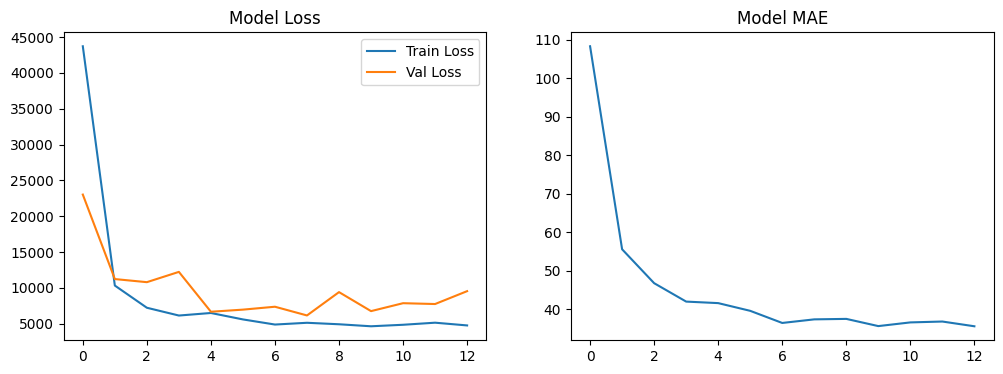

In [ ]:
# Evaluate
test_loss, test_mae = lstm_model.evaluate(X_test, y_test)
print(f"\nTest MAE: {test_mae:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
# plt.plot(history.history['val_mae'], label='Val MAE')
# plt.legend()
plt.title('Model MAE')
plt.show()

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 373120095519506432.0000 - mae: 231412832.0000 - val_loss: 96808691700858880.0000 - val_mae: 155997392.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69340022200860672.0000 - mae: 100000336.0000 - val_loss: 93706230664527872.0000 - val_mae: 157101616.0000
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 109664602559610880.0000 - mae: 112778080.0000 - val_loss: 102314461817208832.0000 - val_mae: 161667664.0000
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 68245076123320320.0000 - mae: 98703464.0000 - val_loss: 94995030090973184.0000 - val_mae: 155946832.0000
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93419481467977728.0000 - mae: 99758040.0000 - val_loss: 94028851427934208.0000 - val_mae: 155279984.0000
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47720063070896128.0000 - mae: 84694144.0000 - val_loss: 7844735432314060

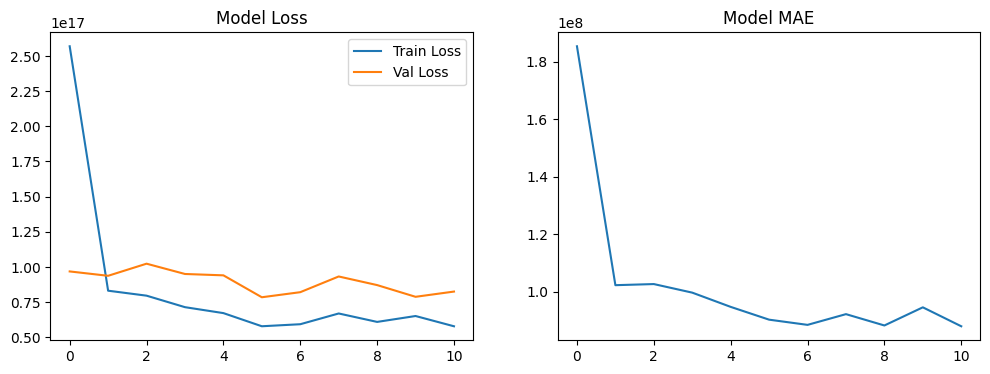

In [ ]:
def run_lstm_on_data(col_label = 'res_policy_count'):
  X, y = prepare_lstm_data(master_df, target_col= col_label, lookback=3)

  split = int(0.85 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  print(f"Training samples: {len(X_train)}")
  print(f"Test samples: {len(X_test)}")

  # Build and train model
  lstm_model = build_lstm_model(lookback=3)

  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,             # Stop if no improvement for 10 epochs
      restore_best_weights=True,  # Restore weights from best epoch
      verbose=1
      )

  history = lstm_model.fit(
      X_train, y_train,
      epochs=100,
      batch_size=32,
      validation_split=0.2,
      callbacks=[early_stop],
      verbose=1
  )

  test_loss, test_mae = lstm_model.evaluate(X_test, y_test)
  print(f"\nTest MAE: {test_mae:.2f}")

  # Plot training history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title('Model Loss')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['mae'], label='Train MAE')
  # plt.plot(history.history['val_mae'], label='Val MAE')
  # plt.legend()
  plt.title('Model MAE')
  plt.show()


run_lstm_on_data('res_exposure_total')

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 295.4752 - mae: 7.5507 - val_loss: 89.6562 - val_mae: 4.6639
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 71.2469 - mae: 3.9869 - val_loss: 64.6188 - val_mae: 3.9670
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 67.9931 - mae: 3.7948 - val_loss: 58.2337 - val_mae: 3.6531
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47.9640 - mae: 3.2631 - val_loss: 35.6748 - val_mae: 3.4293
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.4060 - mae: 3.0982 - val_loss: 30.2278 - val_mae: 3.3312
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.9224 - mae: 2.9978 - val_loss: 17.3493 - val_mae: 2.6555
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.9636 - mae: 2.9182 - val_loss: 40.5846 - val_mae: 3.0196
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.6812 - mae: 3.1224 - val_loss: 23.9179 - val_mae: 2.8043
Epoc

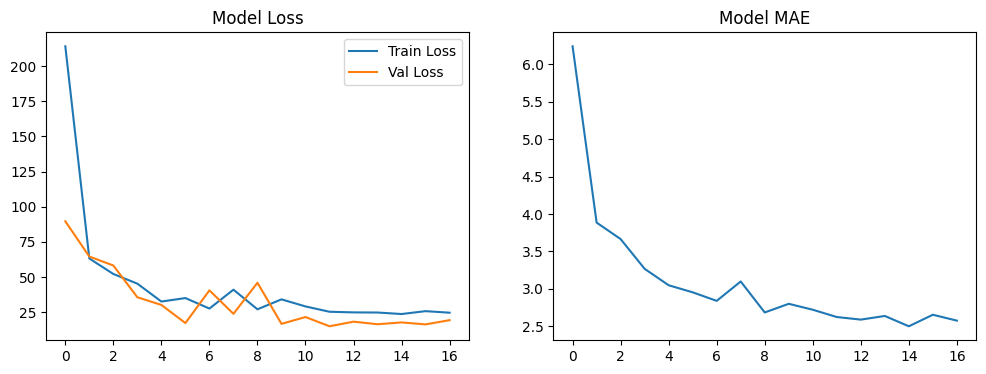

In [ ]:
run_lstm_on_data('com_policy_count')

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2069784199954432.0000 - mae: 17285386.0000 - val_loss: 754232495964160.0000 - val_mae: 12560182.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 728881652826112.0000 - mae: 10873652.0000 - val_loss: 750258443255808.0000 - val_mae: 11632041.0000
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 468405106769920.0000 - mae: 9509013.0000 - val_loss: 630349063258112.0000 - val_mae: 11369824.0000
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 483339815354368.0000 - mae: 9448428.0000 - val_loss: 560378207535104.0000 - val_mae: 11320433.0000
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 443446749822976.0000 - mae: 8898457.0000 - val_loss: 506368188481536.0000 - val_mae: 10014778.0000
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 323377214521344.0000 - mae: 8175342.5000 - val_loss: 426361437028352.0000 - val_mae: 9761545.0000
Epoch 7

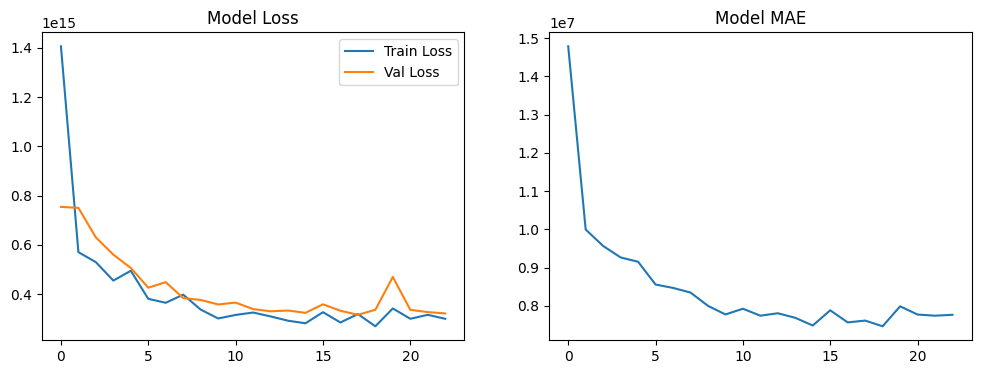

In [ ]:
run_lstm_on_data('com_exposure_total')